In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

"""
Author : Abdulaziz Arif Suria
Date : 04/16/2024
This notebook builds a basic CNN-LSTM based architecture using transfer learning 
"""

'\nAuthor : Abdulaziz Arif Suria\nDate : 04/16/2024\nThis notebook builds a basic CNN-LSTM based architecture using transfer learning \n'

In [5]:
# Constants for file paths, working on Kaggle environment
IMAGE_FOLDER='../input/flickr8k/Images'
CAPTION_FILE='../input/flickr8k/captions.txt'
OUTPUT_PATH='./saved_models'
MODEL_FILE='rnn_cnn_model.pth'

# Imports
import pandas as pd
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import spacy
import torch.nn as nn
import torch.optim as optim
%pip install rouge
from rouge import Rouge
from collections import Counter
from PIL import Image 
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from model import CNN_RNN_network
from data_loader import get_data_loader


Note: you may need to restart the kernel to use updated packages.


In [6]:
# For tokenizer
# After installing spacy, run this command on terminal to load this model
# python -m spacy download en_core_web_sm
spacy_english = spacy.load("en_core_web_sm")

In [6]:
# Read the flickr8k dataset and print the head
caption_df = pd.read_csv(CAPTION_FILE, header=0)
print(f"Shape of caption_df : {caption_df.shape}")
caption_df.head()

Shape of caption_df : (40455, 2)


image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

Maximum caption length : 38
Minimum caption length : 1


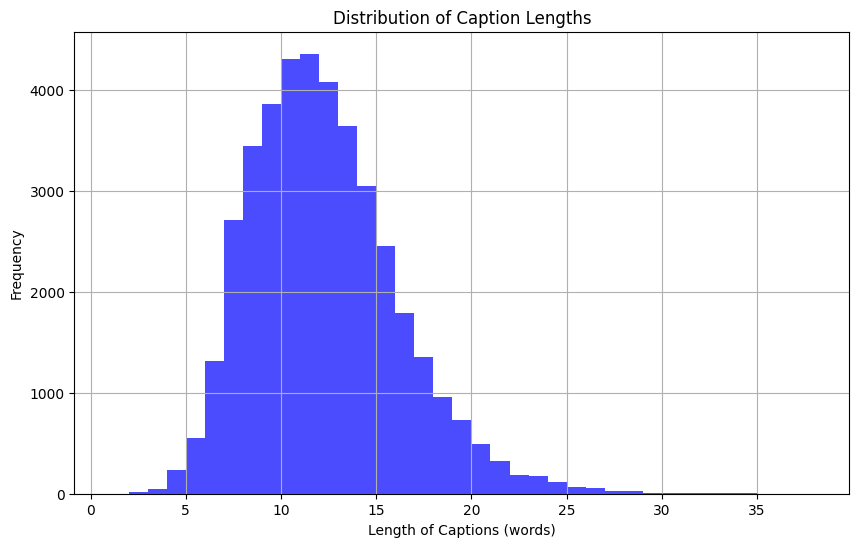

In [7]:
# Plot an histogram of caption lengths and visualize the results
caption_lengths = [len(caption.split()) for caption in caption_df["caption"].tolist()]
print(f"Maximum caption length : {max(caption_lengths)}")
print(f"Minimum caption length : {min(caption_lengths)}")
plt.figure(figsize=(10, 6))
plt.hist(
    caption_lengths,
    bins=range(min(caption_lengths), max(caption_lengths) + 1, 1),
    alpha=0.7,
    color="blue",
)
plt.title("Distribution of Caption Lengths")
plt.xlabel("Length of Captions (words)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [8]:
# Group the dataframe and view the cpations at once for each image
img_group_df = caption_df.groupby("image").agg(list).reset_index()
print(f"Shape of the grouped image df : {img_group_df.shape}")
img_group_df.head()

Shape of the grouped image df : (8091, 2)


image  \
0  1000268201_693b08cb0e.jpg   
1  1001773457_577c3a7d70.jpg   
2  1002674143_1b742ab4b8.jpg   
3  1003163366_44323f5815.jpg   
4  1007129816_e794419615.jpg   

                                             caption  
0  [A child in a pink dress is climbing up a set ...  
1  [A black dog and a spotted dog are fighting, A...  
2  [A little girl covered in paint sits in front ...  
3  [A man lays on a bench while his dog sits by h...  
4  [A man in an orange hat starring at something ...

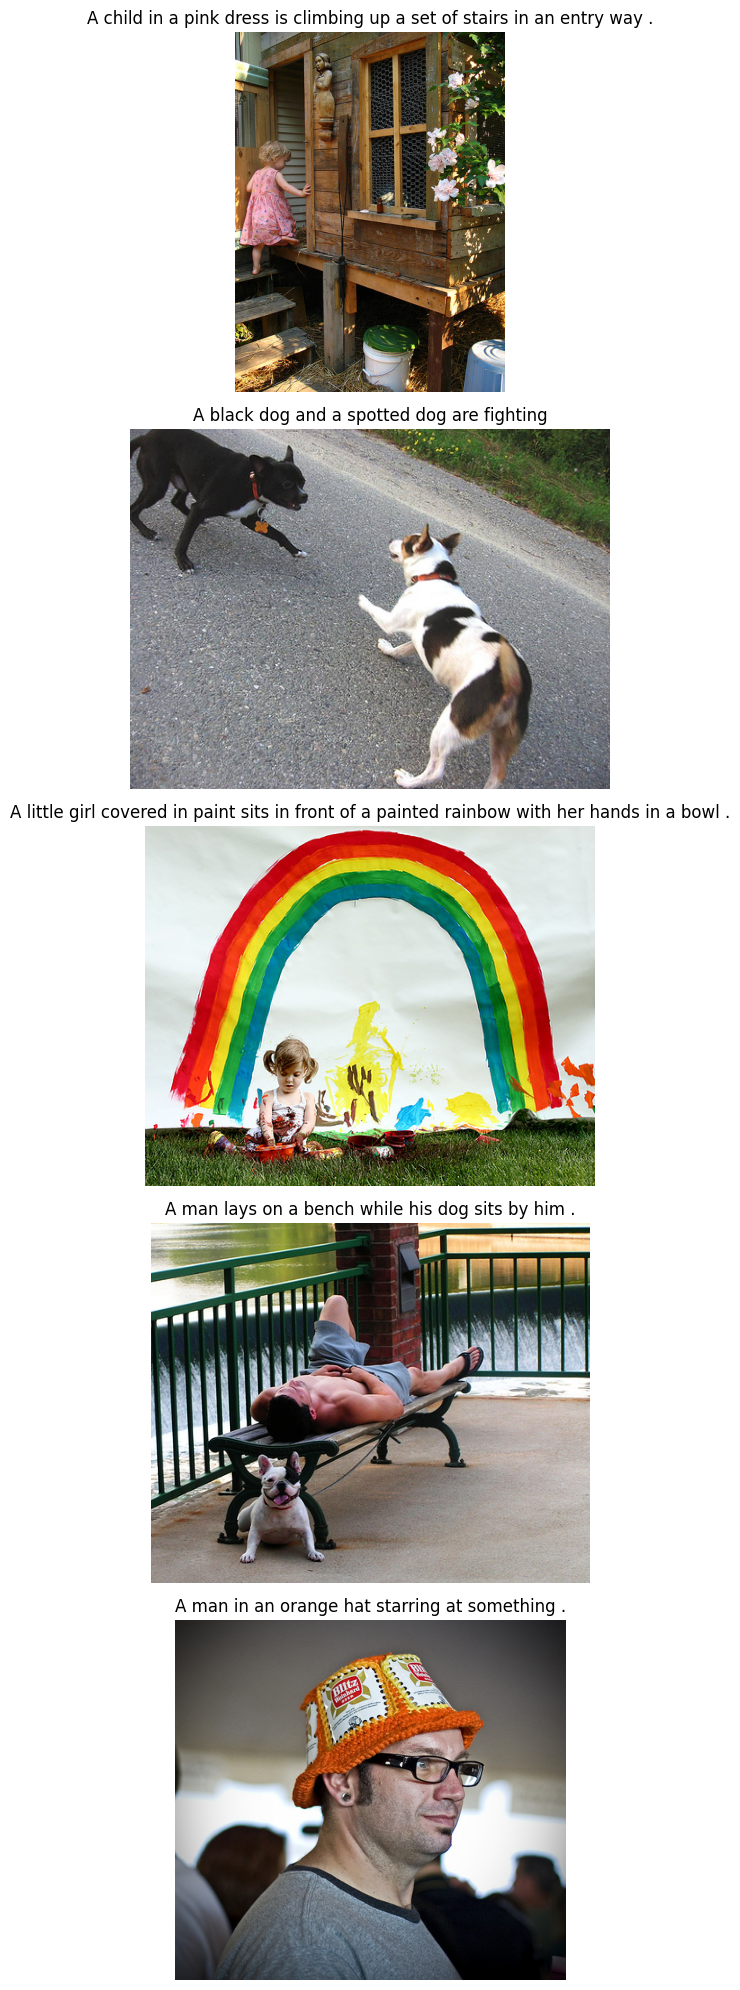

In [9]:
# Visualize a few examples
image_fig, axes = plt.subplots(5, 1, figsize=(16, 20))

for i, ax in enumerate(axes):
    # Load the image from the file path
    img = Image.open(os.path.join(IMAGE_FOLDER, img_group_df["image"][i]))

    ax.imshow(img)
    ax.set_title(img_group_df["caption"][i][0])
    ax.axis("off")

plt.tight_layout()
plt.show()

In [10]:
# Establish constants
VAL_COUNT = 500
TEST_COUNT = 500
START_TOKEN = "<s>"
END_TOKEN = "</s>"
UNK_TOKEN = "<UNK>"
PAD_TOKEN = "<PAD>"

In [11]:
# Perform splitting on the goruped dataframe and print the size of each dataset
train_dataset, val_test_dataset = train_test_split(
    img_group_df, test_size=VAL_COUNT + TEST_COUNT, random_state=42
)
val_dataset, test_dataset = train_test_split(
    val_test_dataset, test_size=TEST_COUNT, random_state=42
)

print(f"Length of Training dataset images: {len(train_dataset)}")
print(f"Length of Validation dataset images: {len(val_dataset)}")
print(f"Length of Testing dataset images: {len(test_dataset)}")

Length of Training dataset images: 7091
Length of Validation dataset images: 500
Length of Testing dataset images: 500


In [12]:
# get a pair of image and caption following the same format earlier
train_dataset = train_dataset.explode("caption").reset_index(drop=True)
val_dataset = val_dataset.explode("caption").reset_index(drop=True)
test_dataset = test_dataset.explode("caption").reset_index(drop=True)

In [15]:
flickr_transform = transforms.Compose(
    [
        # Inception model compatible image size
        transforms.Resize((356, 356)),
        # As each image is read 5 times for each different caption, we can do some data augmentation
        transforms.RandomCrop((299, 299)),
        transforms.ToTensor(),
        # Normalize for inception model copatibility
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

In [ ]:
# Transform function used in evaluation, we don't do randomCrop here
eval_transform = transforms.Compose(
    [
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

In [19]:
# Load the train data into data loader and print the shapes
train_loader, train_set = get_data_loader(train_dataset, flickr_transform)
# Caption size is adjusted according to the batch size max
for idx, (images, captions) in enumerate(train_loader):
    print(f"Shape of the image tensors : {images.shape}")
    print(f"Shape of the caption tensors : {captions.shape}")
    if idx + 1 == 5:
        break

Shape of the image tensors : torch.Size([32, 3, 299, 299])
Shape of the caption tensors : torch.Size([26, 32])
Shape of the image tensors : torch.Size([32, 3, 299, 299])
Shape of the caption tensors : torch.Size([24, 32])
Shape of the image tensors : torch.Size([32, 3, 299, 299])
Shape of the caption tensors : torch.Size([25, 32])
Shape of the image tensors : torch.Size([32, 3, 299, 299])
Shape of the caption tensors : torch.Size([22, 32])
Shape of the image tensors : torch.Size([32, 3, 299, 299])
Shape of the caption tensors : torch.Size([23, 32])


In [20]:
# load the test and validation data loader
val_loader, val_set = get_data_loader(val_dataset, eval_transform)
test_loader, test_set = get_data_loader(test_dataset, eval_transform)

In [ ]:
"""
Evaluate model on validation dataset after every epoch by passing the necessary parameters.
"""
def get_validation_loss(embedding_size,hidden_size,vocab_size,layers,val_loader,device):
    model = CNN_RNN_network(embedding_size, hidden_size, vocab_size, layers,is_training=False)
    model.load_state_dict(torch.load(os.path.join(OUTPUT_PATH,MODEL_FILE)))
    model.eval()  
    model.to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=train_set.vocabulary.word_idx_map[PAD_TOKEN])
    total_val_loss = 0
    with torch.no_grad():
        for images, captions in val_loader:
            images = images.to(device)
            captions = captions.to(device)

            outputs = model(images, captions[:-1])
            val_loss = criterion(
                outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
            )
            total_val_loss += val_loss.item()
        average_val_loss = total_val_loss / len(val_loader)
    return average_val_loss

In [24]:
def train_network(device, embedding_size, hidden_size, vocab_size, layers):
    """

    Trains the CNN-RNN neural network
    device : GPU or CPU for faster processing

    HYPERPARAMETERS:
    embedding size : Initial embedding size
    hidden_size : The size of the units of hidden layers
    vocab_size : The size of the vocabulary
    layers : number of layers
    
    """
    train_loader, train_set = get_data_loader(train_dataset, flickr_transform)

    # Hyperparameters
    learning_rate = 3e-4
    epochs = 100

    # Create Model
    model = CNN_RNN_network(embedding_size, hidden_size, vocab_size, layers).to(device)

    # Loss Criterion and optimizer
    criterion = nn.CrossEntropyLoss(
        ignore_index=train_set.vocabulary.word_idx_map[PAD_TOKEN]
    )
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Transfer learning on last layer only for the Inception v3 Model
    for name, param in model.encoderCNN.inception_model.named_parameters():
        if "fc.weight" in name or "fc.bias" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

    # Training Mode
    model.train()
    loss_history = []
    val_loss_history=[]

    for epoch in range(epochs):
        total_loss = 0
        for idx, (images, captions) in tqdm(
            enumerate(train_loader), total=len(train_loader), leave=False
        ):
            # Training and loss calculation
            images = images.to(device)
            captions = captions.to(device)

            outputs = model(images, captions[:-1])
            loss = criterion(
                outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
            )
            total_loss += loss.item()

            optimizer.zero_grad()
            loss.backward(loss)
            optimizer.step()
        average_loss = total_loss / len(train_loader)
        loss_history.append(average_loss)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {average_loss:.4f}")

        torch.save(model.state_dict(), os.path.join(OUTPUT_PATH,MODEL_FILE))
        # Calculate Validation loss
        val_loss_history.append(get_validation_loss(embedding_size,hidden_size,vocab_size,layers,val_loader,device))

    return model, loss_history, val_loss_history

In [25]:
# Run the function by passing the arguments
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_size = 512
hidden_size = 256
vocab_size = len(train_set.vocabulary)
layers = 2
model, loss_history, val_loss_history = train_network(
    device, embedding_size, hidden_size, vocab_size, layers
)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:02<00:00, 43.5MB/s] 
                                                   

Epoch 1/100, Loss: 4.0123


Epoch 2/100, Loss: 3.3259


Epoch 3/100, Loss: 3.1085


Epoch 4/100, Loss: 2.9592


Epoch 5/100, Loss: 2.8590


Epoch 6/100, Loss: 2.7814


Epoch 7/100, Loss: 2.7133


Epoch 8/100, Loss: 2.6567


Epoch 9/100, Loss: 2.6088


Epoch 10/100, Loss: 2.5652


Epoch 11/100, Loss: 2.5287


Epoch 12/100, Loss: 2.4937


Epoch 13/100, Loss: 2.4629


Epoch 14/100, Loss: 2.4345


Epoch 15/100, Loss: 2.4080


Epoch 16/100, Loss: 2.3846


Epoch 17/100, Loss: 2.3612


Epoch 18/100, Loss: 2.3403


Epoch 19/100, Loss: 2.3201


Epoch 20/100, Loss: 2.3003


Epoch 21/100, Loss: 2.2820


Epoch 22/100, Loss: 2.2659


Epoch 23/100, Loss: 2.2493


Epoch 24/100, Loss: 2.2333


Epoch 25/100, Loss: 2.2172


Epoch 26/100, Loss: 2.2031


Epoch 27/100, Loss: 2.1892


Epoch 28/100, Loss: 2.1737


Epoch 29/100, Loss: 2.1625


Epoch 30/100, Loss: 2.1487


Epoch 31/100, Loss: 2.1360


Epoch 32/100, Loss: 2.1244


Epoch 33/100, Loss: 2.1122


Epoch 34/100, Loss: 2.1017


Epoch 35/100, Loss: 2.0897


Epoch 36/100, Loss: 2.0803


Epoch 37/100, Loss: 2.0674


Epoch 38/100, Loss: 2.0575


Epoch 39/100, Loss: 2.0463


Epoch 40/100, Loss: 2.0359


Epoch 41/100, Loss: 2.0266


Epoch 42/100, Loss: 2.0175


Epoch 43/100, Loss: 2.0080


Epoch 44/100, Loss: 1.9987


Epoch 45/100, Loss: 1.9886


Epoch 46/100, Loss: 1.9798


Epoch 47/100, Loss: 1.9706


Epoch 48/100, Loss: 1.9629


Epoch 49/100, Loss: 1.9538


Epoch 50/100, Loss: 1.9452


Epoch 51/100, Loss: 1.9371


Epoch 52/100, Loss: 1.9303


Epoch 53/100, Loss: 1.9213


Epoch 54/100, Loss: 1.9144


Epoch 55/100, Loss: 1.9057


Epoch 56/100, Loss: 1.8978


Epoch 57/100, Loss: 1.8891


Epoch 58/100, Loss: 1.8820


Epoch 59/100, Loss: 1.8737


Epoch 60/100, Loss: 1.8694


Epoch 61/100, Loss: 1.8620


Epoch 62/100, Loss: 1.8559


Epoch 63/100, Loss: 1.8477


Epoch 64/100, Loss: 1.8398


Epoch 65/100, Loss: 1.8342


Epoch 66/100, Loss: 1.8248


Epoch 67/100, Loss: 1.8194


Epoch 68/100, Loss: 1.8127


Epoch 69/100, Loss: 1.8062


Epoch 70/100, Loss: 1.8000


Epoch 71/100, Loss: 1.7935


Epoch 72/100, Loss: 1.7873


Epoch 73/100, Loss: 1.7829


Epoch 74/100, Loss: 1.7770


Epoch 75/100, Loss: 1.7702


Epoch 76/100, Loss: 1.7633


Epoch 77/100, Loss: 1.7578


Epoch 78/100, Loss: 1.7520


Epoch 79/100, Loss: 1.7458


Epoch 80/100, Loss: 1.7428


Epoch 81/100, Loss: 1.7354


Epoch 82/100, Loss: 1.7304


Epoch 83/100, Loss: 1.7252


Epoch 84/100, Loss: 1.7190


Epoch 85/100, Loss: 1.7129


Epoch 86/100, Loss: 1.7087


Epoch 87/100, Loss: 1.7039


Epoch 88/100, Loss: 1.6991


Epoch 89/100, Loss: 1.6943


Epoch 90/100, Loss: 1.6878


Epoch 91/100, Loss: 1.6834


Epoch 92/100, Loss: 1.6788


Epoch 93/100, Loss: 1.6731


Epoch 94/100, Loss: 1.6688


Epoch 95/100, Loss: 1.6649


Epoch 96/100, Loss: 1.6595


Epoch 97/100, Loss: 1.6548


Epoch 98/100, Loss: 1.6519


Epoch 99/100, Loss: 1.6449


Epoch 100/100, Loss: 1.6404
Model saved


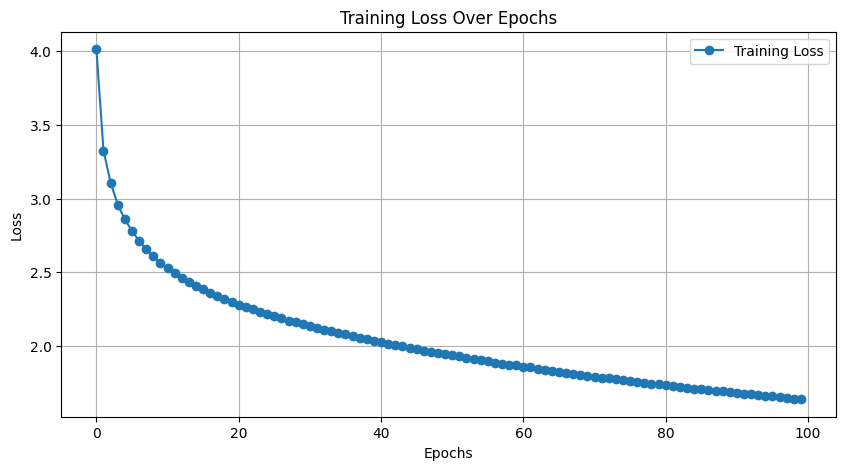

In [27]:
# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label="Training Loss", marker="o")
plt.title("Training Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

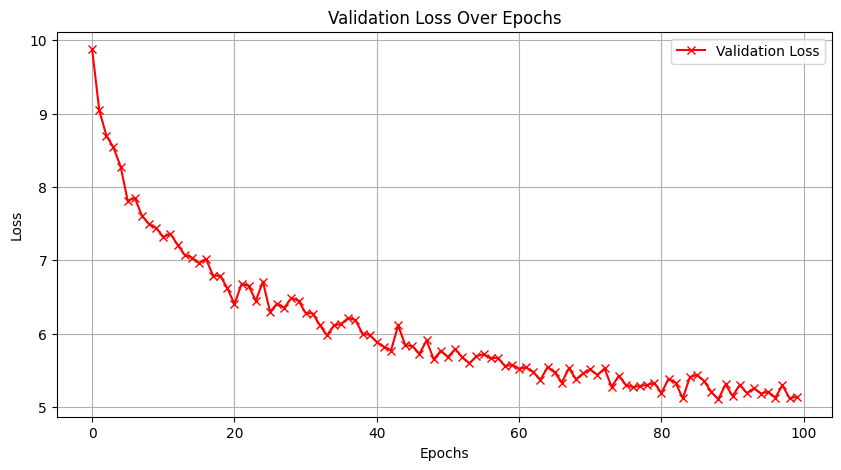

In [3]:
# Plotting the training loss
plt.figure(figsize=(10, 5))  
plt.plot(val_loss_history,label='Validation loss',marker='x',color='r')
plt.title('Validation Loss Over Epochs') 
plt.xlabel('Epochs')  
plt.ylabel('Loss')  
plt.legend()  
plt.grid(True)  
plt.show() 

In [ ]:
def calculate_rouge_score(image_captions,predicted_caption):
    """
    Function which calculates the best the rouge-l f-score  for a given list of image captions against the predicted caption
    """

    rouge=Rouge()
    caption_score_map={}
    for caption in image_captions:
        caption_score_map[caption]=rouge.get_scores(predicted_caption, caption)[0]['rouge-l']['f']
    best_match=max(caption_score_map,key=caption_score_map.get)
    best_score=round(caption_score_map[best_match],3)
    return (best_match,best_score)

In [ ]:
# Run the function by passing the arguments and load the model
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_size = 512
hidden_size = 256
vocab_size = len(train_set.vocabulary)
layers = 2
model = CNN_RNN_network(embedding_size, hidden_size, vocab_size, layers,is_training=False)
model.load_state_dict(torch.load(os.path.join(OUTPUT_PATH,MODEL_FILE)))
model.eval()  
model.to(device)
print("Model loaded!")

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 154MB/s] 


Model loaded!


In [ ]:
val_idx=0
val_images=val_set.images
val_captions=val_set.captions
rouge_score_map={}
while val_idx <len(val_captions):
    image_captions=val_captions[val_idx:val_idx+5]
    display_image= Image.open(os.path.join(IMAGE_FOLDER,val_images[val_idx]))
    transform_image=eval_transform(display_image).unsqueeze(0)
    predicted_caption=model.caption_image(transform_image.to(device),train_set.vocabulary)
    caption_string=' '.join(predicted_caption[1:-1])
    best_caption,best_score=calculate_rouge_score(image_captions,caption_string)
    rouge_score_map[val_images[val_idx]]=(best_caption,caption_string,best_score)
    val_idx+=5
print(len(rouge_score_map))

500


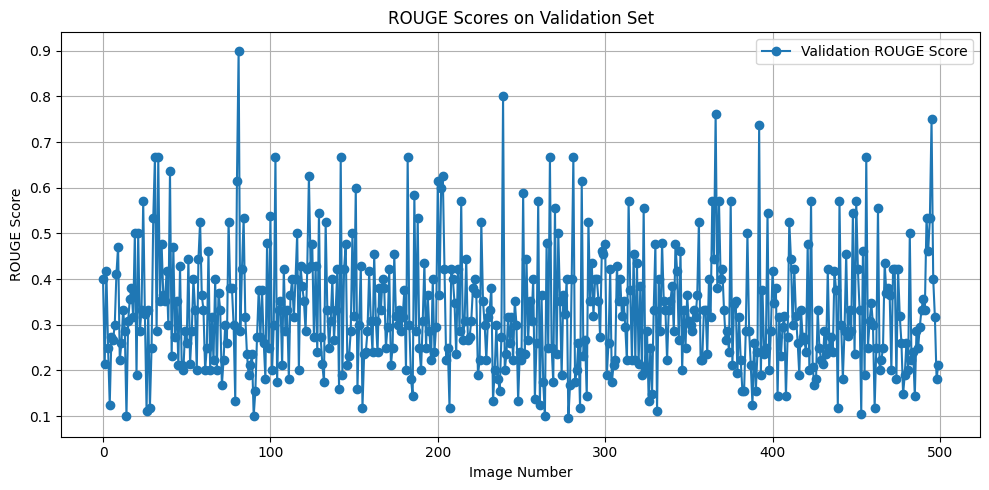

In [ ]:
rouge_scores = [rouge_score_map[image][2] for image in rouge_score_map]
plt.figure(figsize=(10, 5)) 
plt.plot(rouge_scores, label='Validation ROUGE Score', marker='o')  


plt.title('ROUGE Scores on Validation Set')
plt.xlabel('Image Number')
plt.ylabel('ROUGE Score')


plt.legend()

plt.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
rouge_scores=[score_map[2] for score_map in rouge_score_map.values()]
print(f"Average Rouge Score for validation set : {sum(rouge_scores)/len(rouge_scores):.3f}")

Average Rouge Score for validation set : 0.329


In [ ]:
test_idx=0
test_images=test_set.images
test_captions=test_set.captions
rouge_score_map={}
while test_idx <len(test_captions):
    image_captions=test_captions[test_idx:test_idx+5]
    display_image= Image.open(os.path.join(IMAGE_FOLDER,test_images[test_idx]))
    transform_image=eval_transform(display_image).unsqueeze(0)
    predicted_caption=model.caption_image(transform_image.to(device),train_set.vocabulary)
    caption_string=' '.join(predicted_caption[1:-1])
    best_caption,best_score=calculate_rouge_score(image_captions,caption_string)
    rouge_score_map[test_images[test_idx]]=(best_caption,caption_string,best_score)
    test_idx+=5
print(len(rouge_score_map))

500


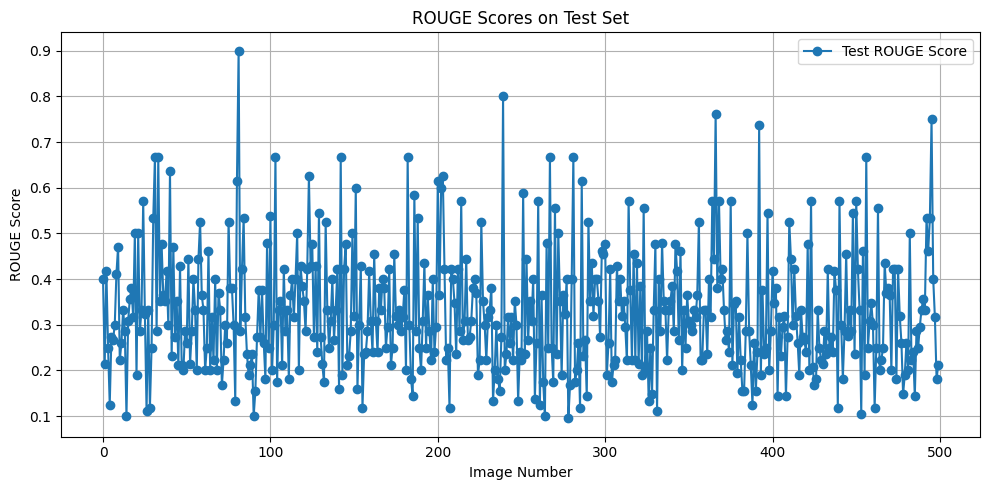

In [ ]:
rouge_scores = [rouge_score_map[image][2] for image in rouge_score_map]
plt.figure(figsize=(10, 5)) 
plt.plot(rouge_scores, label='Test ROUGE Score', marker='o')  
plt.title('ROUGE Scores on Test Set')
plt.xlabel('Image Number')
plt.ylabel('ROUGE Score')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
rouge_scores=[score_map[2] for score_map in rouge_score_map.values()]
print(f"Average Rouge Score for Test set : {sum(rouge_scores)/len(rouge_scores):.3f}")

Average Rouge Score for Test set : 0.336


In [ ]:
def plot_top_frequent_words(caption_list,title,top_count=50):
    words=[]
    for caption in caption_list:
        caption_tokenized=[token.text.lower() for token in spacy_english.tokenizer(caption)]
        words.extend(caption_tokenized)
    total_freq=Counter(words)
    total_freq=total_freq.most_common(top_count)
    words, frequencies = zip(*total_freq)
    plt.figure(figsize=(12, 6))
    plt.bar(words, frequencies)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()
    
        

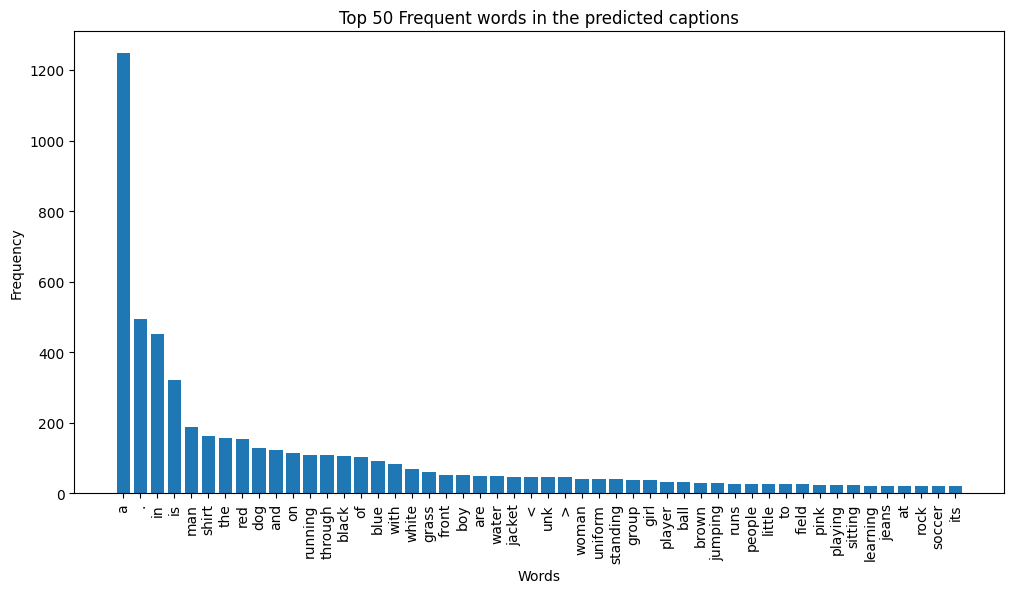

In [ ]:
predicted_captions=[score_map[1] for score_map in rouge_score_map.values()]
prediction_title="Top 50 Frequent words in the predicted captions"
plot_top_frequent_words(predicted_captions,prediction_title)

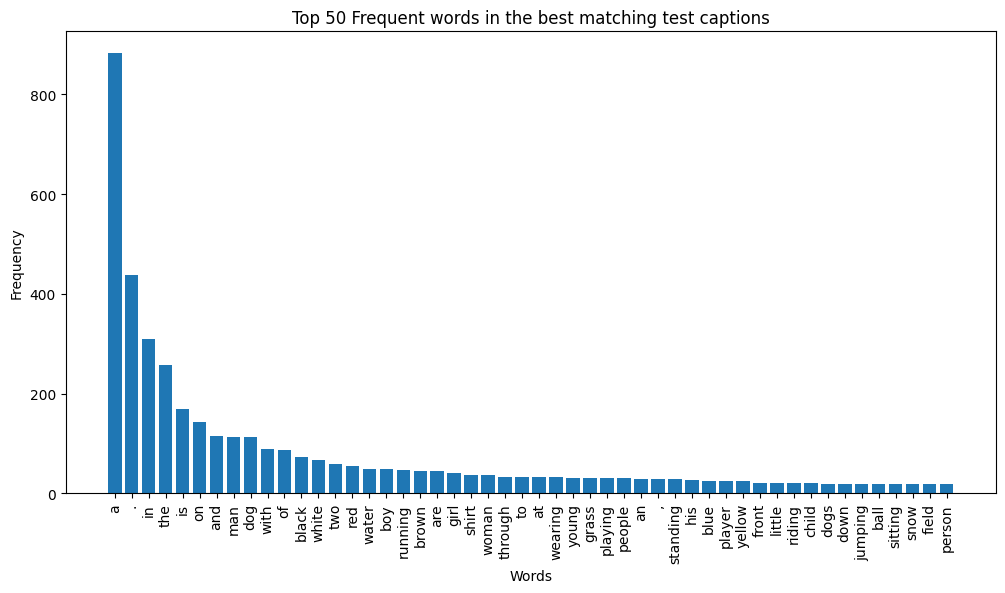

In [ ]:
test_captions=[score_map[0] for score_map in rouge_score_map.values()]
test_title="Top 50 Frequent words in the best matching test captions"
plot_top_frequent_words(test_captions,test_title)

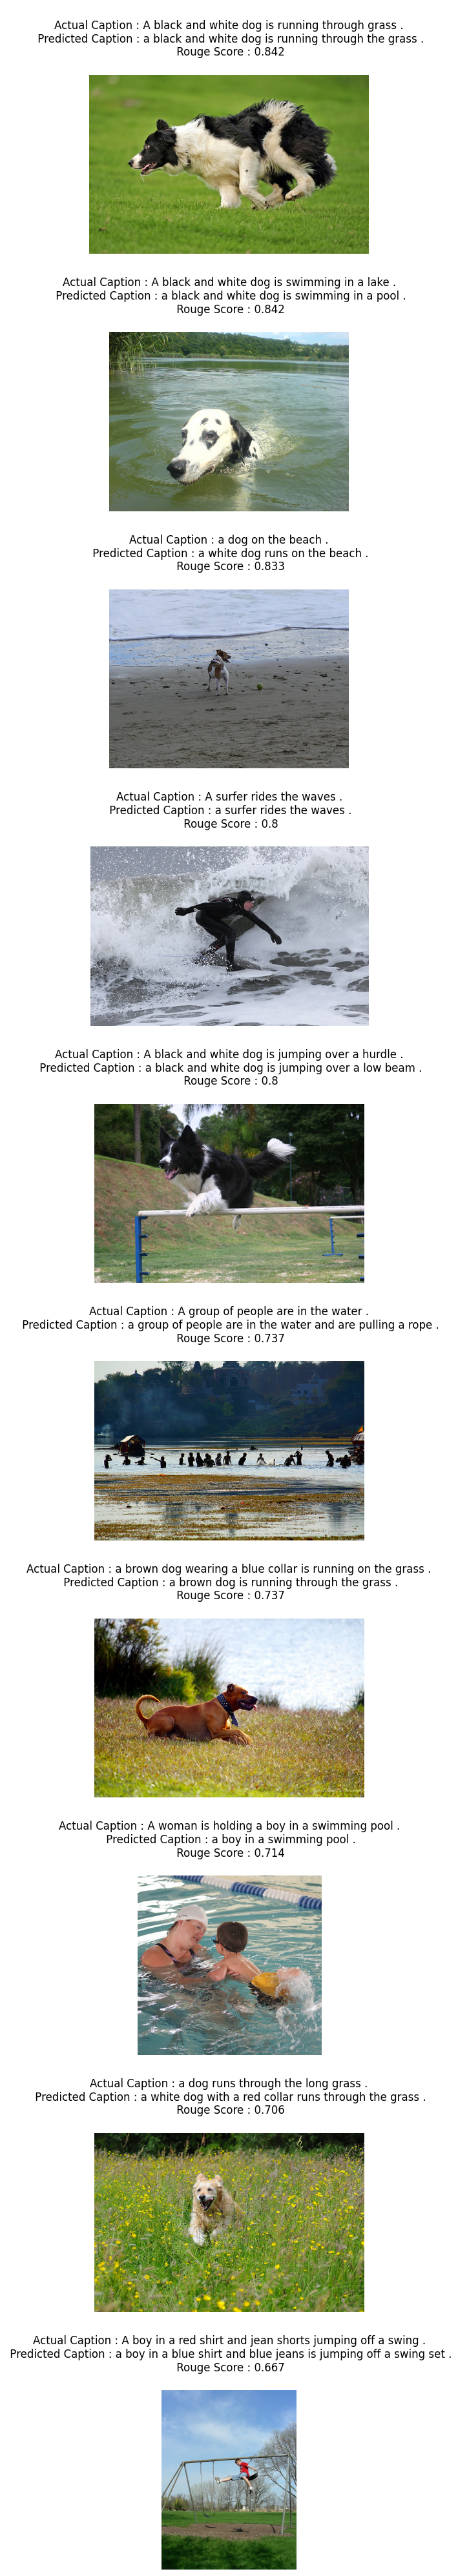

In [ ]:
# Visualizing top 10 best results on test dataset
image_fig, axes = plt.subplots(10, 1, figsize=(16, 40))
ax_idx=0
best_results=dict(sorted(rouge_score_map.items(),key=lambda x : x[1][2],reverse=True)[:10])
for image,caption_data in best_results.items():
    display_image= Image.open(os.path.join(IMAGE_FOLDER,image))
    axes[ax_idx].imshow(display_image)
    best_caption,predicted_caption,score=caption_data
    axes[ax_idx].set_title(f"\nActual Caption : {best_caption}\n Predicted Caption : {predicted_caption}\n Rouge Score : {score}\n")
    axes[ax_idx].axis('off')
    ax_idx+=1

plt.tight_layout()
plt.show()


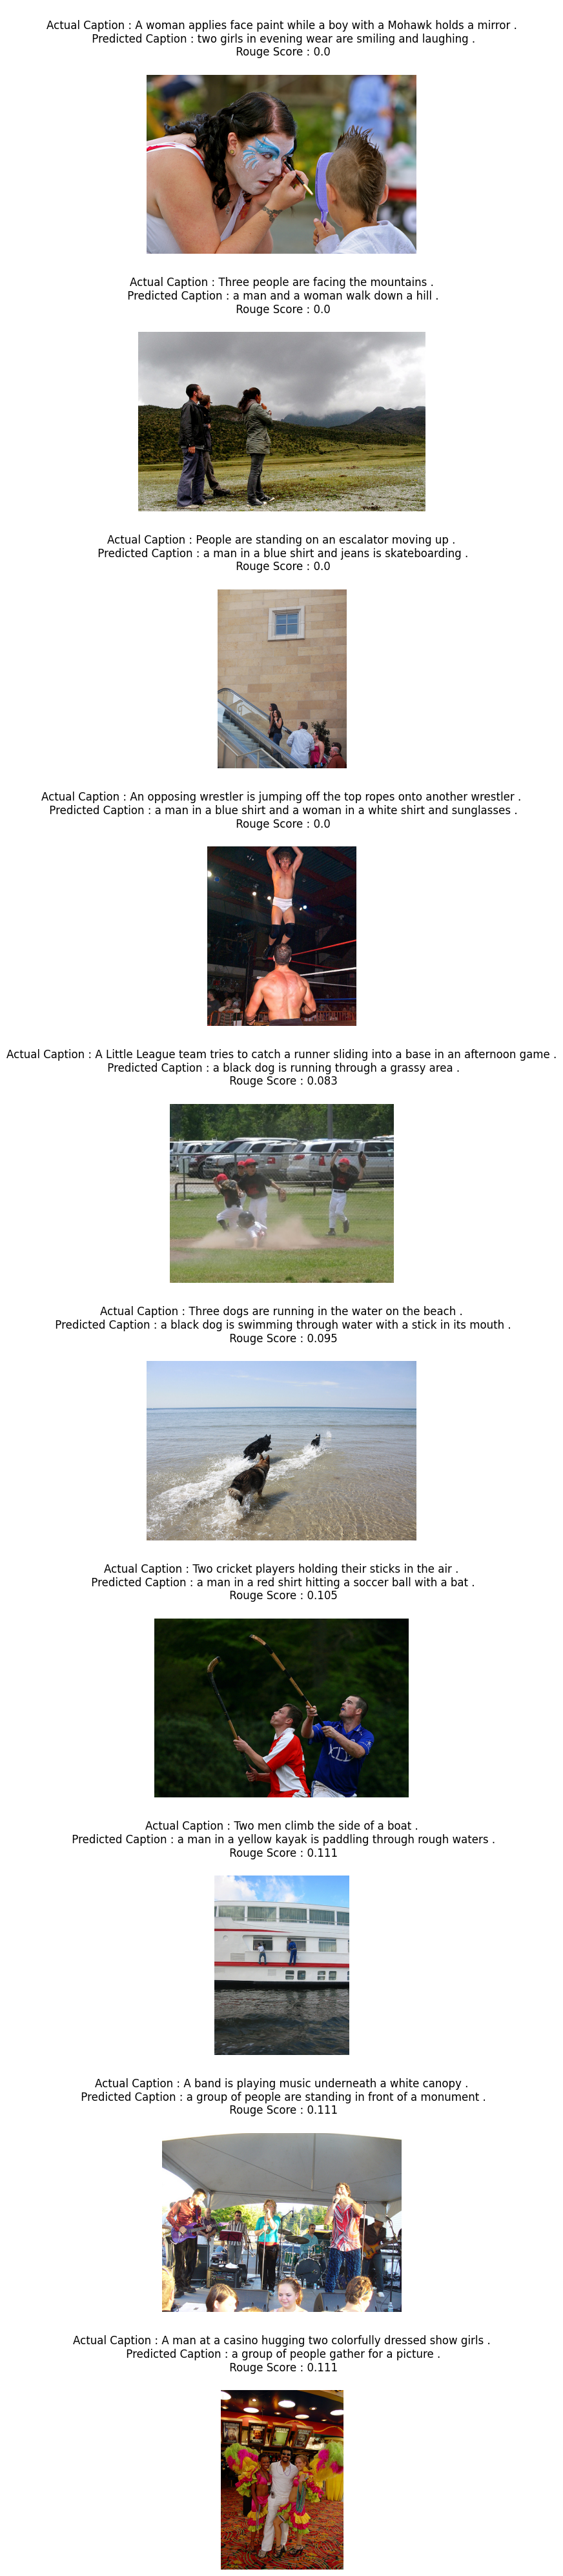

In [ ]:
# Visualizing top 10 worst results on Test dataset
image_fig, axes = plt.subplots(10, 1, figsize=(16, 40))
ax_idx=0
best_results=dict(sorted(rouge_score_map.items(),key=lambda x : x[1][2])[:10])
for image,caption_data in best_results.items():
    display_image= Image.open(os.path.join(IMAGE_FOLDER,image))
    axes[ax_idx].imshow(display_image)
    best_caption,predicted_caption,score=caption_data
    axes[ax_idx].set_title(f"\nActual Caption : {best_caption}\n Predicted Caption : {predicted_caption}\n Rouge Score : {score}\n")
    axes[ax_idx].axis('off')
    ax_idx+=1

plt.tight_layout()
plt.show()